In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Derivative of a simple function with one input
$y=3x^2-4x+5$

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

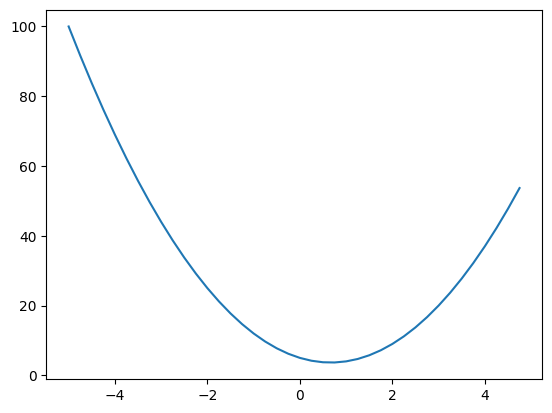

In [4]:
xs = np.arange(-5.0, 5.0, 0.25)
ys = f(xs)
plt.plot(xs, ys)

Then what about the derivative of this y. We do not do what we did in calcus class to write out all terms on paper. We just need to know what it means by its definitation.
> If we slightly bump up by small number `h`, how does the function respond. The slope response goes up or goes down and by how much.
https://en.wikipedia.org/wiki/Derivative
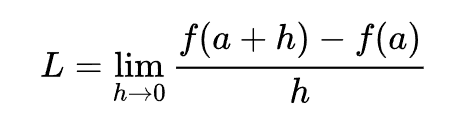

In [5]:
h = 0.00001
a = 3.0 # x = -3.0 going down, x = 2/3 almost stay the same
how_function_respond = f(a + h) - f(a) # The function will go up or go down
normalized_respond_slope = how_function_respond / h
normalized_respond_slope

14.00003000000538

## Derivative of a function with multiple inputs

In [6]:
# Inputs
a = 2.0
b = -3.0
c = 10.0

h = 0.00001
d1 = a*b + c
# Bump up a. Also try b and c
a += h
d2 = a*b + c

# a is slight more positive but b is a negative number
(d2 - d1) / h

-3.000000000064062

## Starting core `Value` object

In [7]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._prev = set(_children) # Used for keep a expr graph to know what values produce current value
        self._op = _op # Operation happens
        self.label = label
        
    def __repr__(self):
        # Wraper is to provide us a way to print a nice-looking expr
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        # It should not be self.data + other, cause other is an obj
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
d = a*b; d.label = 'd'
e = d + c; e.label = 'e'
f = Value(-2.0, label='f')
L = e * f; L.label = 'L'
L

Value(data=-8.0)

In [8]:
L._prev, L._op

({Value(data=-2.0), Value(data=4.0)}, '*')

In [9]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(node):
        if node not in nodes:
            nodes.add(node)
        for child in node._prev:
            edges.add((child, node))
            build(child)
    build(root)
    return nodes, edges

def draw(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for node in nodes:
        uid = str(id(node))
        dot.node(name=uid, label="%s | data %.4f | grad %.4f" % (node.label, node.data, node.grad), shape='record')
        if node._op:
            dot.node(name=uid + node._op, label=node._op)
            dot.edge(uid + node._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

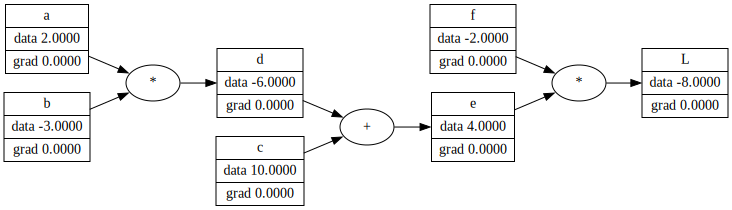

In [10]:
draw(L)

Run backprop. Reverse from `L` to calculate gradients along all intermediate values. The derivatives respect to `L` of every node will be calculated. Some of these `a`, `b`, `c` and `f` will eventually represent weights in nerual networks, we are very interested in how these weights impacting the loss function which is basically the derivative. Others will be data which are fixed and weights are iterative.

Initially, we assume every node has no effect on the output. Thus the gradient of each node is set to `0`.

## Back Propgation
### Example 1

In [29]:
# Mannual calculcation of gradients
def lol():
    # Inline gradient check for all intermediate node.
    h = 0.000001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    d = a*b; d.label = 'd'
    e = d + c; e.label = 'e';
    f = Value(-2.0, label='f')
    L = e * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0+h, label='b')
    c = Value(10.0, label='c')
    d = a*b; d.label = 'd'
    e = d + c; e.label = 'e';
    f = Value(-2.0, label='f')
    L = e * f; L.label = 'L'
    L2 = L.data
    
    print((L2 - L1) / h)
lol()

-4.000000000559112


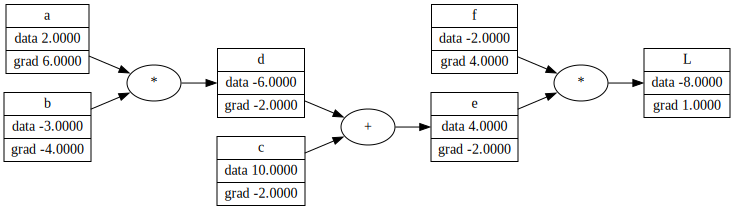

In [30]:
L.grad = 1

# Then look at the derivatives of L wrt. e and f
# L = e * f. dL / de = f, symmetrically dL / df = e
e.grad = -2.0
f.grad = 4.0

# If you know how c impacts e and how e impacts L
# You can somehow put impacts together and know how c impacts L
# Chain Rule:
# dL / dc = (dL / de) * (de / dc)
# Local derivative: e = d + c -> de / dc = 1
# dL / dc = e.grad * 1 = -2.0
c.grad = e.grad * 1
d.grad = e.grad * 1

# dL / da = (dL / de) * (de / dd) * (dd / da)
# d = a * b -> dd / da = b
# KNOWN: (dL / de) * (de / dd) = dL / dd = -2.0
# dL / da = -2.0 * -3.0 = 6.0
a.grad = 6.0
b.grad = -4.0

draw(L)

One step optimization

In [32]:
   # Nudge all inputs(leaf nodes) to increase L to make it close to 0
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

d = a * b
e = d + c
L = e * f
print(L.data)

-7.286496


### Example 2: Neuron